# GSR Ingestion and Normalization

In [24]:
from datetime import datetime, time

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## The Algorithm

The whole ingestion and normalization algorithm does this to all .csv files in the given directory:
   * interpolates to get regularly spaced samples
   * truncates to get identical durations
   * normalizes value range to range from 0 to 1

In [25]:
def normalized_series_from_dataframe(df):
    '''
    ingests and normalizes a dataframe into a normalized GSR response series with a datetime index
    input: dataframe
    output: pandas series
    '''
    x = df
    x['Name'] = x['Name'].apply(lambda x: ' '.join(x.split('-')[:2]))
    x['Timestamp'] = pd.to_datetime(x['Timestamp'],  format="%Y%m%d_%H%M%S%f")
    x = x.set_index('Timestamp')
    # shift back to midnight to normalize series timestamps
    norm_timedelta = x.index[0] - datetime(year=2019, month=2, day=27, hour=0, minute=0, second=0)
    x.index = x.index - norm_timedelta
    raw_gsr_column_name = list(x.columns)[-1]
    series = x[raw_gsr_column_name]
    series = series.rename(x['Name'][0])
    return series

def interpolate_series_timestamps(s):
    '''
    applies linear interpolation to series to give samples even spacing at every 25 milliseconds
    input: pandas series
    output: pandas series
    '''
    s = s.groupby(s.index).mean() # eliminate duplicate values by averaging repeated indexes 
    upsampled = s.resample('.1S')
    interpolated = upsampled.interpolate(method='linear')
    return interpolated

def truncate_series_list_to_duration_of_shortest_series(series_list):
    '''
    truncates all files to be duration of shortest file
    input: list of dataframes
    output: list of dataframes with same ending timestamp
    '''
    last_timestamps = [x.index[-1] for x in series_list]
    min_time = min(last_timestamps)
    return [s.truncate(after=min_time) for s in series_list]

def ingest_dir_as_dataframes(the_dir):
    '''
    ingests a directory of .csv files and returns them as a list of dataframes
    '''
    path = the_dir
    all_files = glob.glob(path + "/*.csv")
    the_frames = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=2)
        the_frames.append(df)
    return the_frames

def normalize_series_range(the_series):
    the_series = the_series - the_series.min() # shift data from 0 to new max
    the_series = the_series.divide(the_series.max()) * 1.0
    return the_series

def post_process_column_names(df):
    names = [name.replace(' ', '').replace('Day', 'D') for name in df.columns]
    df.columns = names

def ingest_and_normalize_dir(the_dir):
    '''
    ingests a directory of .csv files and outputs a dataframe in which each column is a normalized series
    '''
    the_frames = ingest_dir_as_dataframes(the_dir)
    series_list = [normalized_series_from_dataframe(df) for df in the_frames]
    series_list = [interpolate_series_timestamps(s) for s in series_list]
    series_list = truncate_series_list_to_duration_of_shortest_series(series_list)
    series_list = [normalize_series_range(s) for s in series_list]
    df = pd.concat(series_list, axis=1, keys=[s.name for s in series_list])
    df.columns = [name.replace(' ', '').replace('Day', 'D') for name in df.columns]
    return df

In [26]:
df = ingest_and_normalize_dir('../../data/raw/GSR Audio Sensor Data- 9.3.19')

In [27]:
df.head()

,D5S2P2,D5S1P2,D7P1,D10P1,D4S1P2,D3S2P2,D6S2P1,D9S2P1,D8P2,D9S1P1,...,D9S1P2,D9S2P2,D8P1,D4S1P1,D3S2P1,D6S2P2,D7P2,D10P2,D5S1P1,D5S2P1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-27 00:00:00.000,0.998752,0.991364,0.184426,0.000000,0.677947,0.996364,1.000000,1.000000,0.965902,0.923713,...,0.730392,0.242199,0.431274,0.730473,0.777923,0.000000,0.945385,0.398319,1.000000,0.996313
2019-02-27 00:00:00.100,0.998627,0.993130,0.183866,0.001657,0.713926,1.000000,0.995817,1.000000,0.965246,0.925213,...,0.742997,0.239585,0.428031,0.728946,0.779861,0.000000,0.940769,0.397899,0.999554,0.996108
2019-02-27 00:00:00.200,0.998502,0.994897,0.183306,0.003315,0.749905,0.998788,0.991633,1.000000,0.964918,0.926713,...,0.755602,0.236971,0.424788,0.727419,0.780829,0.000000,0.943846,0.409244,0.999108,0.995903
2019-02-27 00:00:00.300,0.998377,0.995010,0.182746,0.004972,0.726746,0.997576,0.988188,0.998311,0.964590,0.928214,...,0.768207,0.234618,0.421546,0.725892,0.781798,0.000762,0.945897,0.410924,0.998662,0.995699
2019-02-27 00:00:00.400,0.998252,0.995124,0.182185,0.006629,0.703587,0.996364,0.985432,0.996622,0.966448,0.929714,...,0.780812,0.232265,0.418303,0.724976,0.782767,0.000898,0.947949,0.411765,0.996877,0.995494


write out normalized df as .csv

In [28]:
df.to_csv('../../data/intermediary/normedGSRaudioSensorData.csv')

How long are the time series?

In [29]:
df.index[-1]

Timestamp('2019-02-27 00:11:21.500000', freq='100L')

All participants, each normalized between 0 and 1 individually:

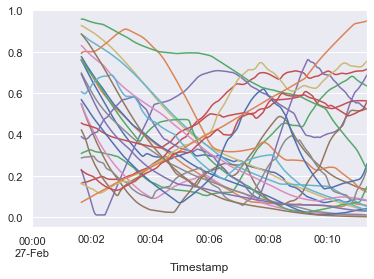

In [30]:
df.rolling(1000).mean().plot(legend=False)

Only downward-trending participants, each normalized between 0 and 1 individually:

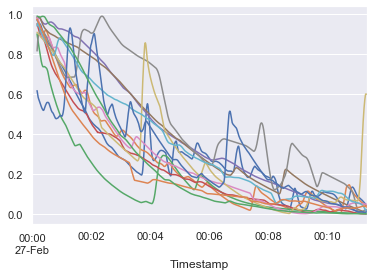

In [31]:
lower = [0, 1, 6, 7, 8, 9, 10, 11, 12, 16, 19, 24, 25]
cols = [df.columns[x] for x in lower]
lowers_df = df[cols]
lowers_df.rolling(100).mean().plot(legend=False)

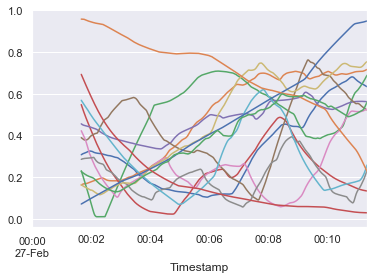

In [32]:
higher = [2, 3, 4, 5, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24]
cols = [df.columns[x] for x in higher]
lowers_df = df[cols]
lowers_df.rolling(1000).mean().plot(legend=False)

## Subtract Trend from Decreasing Subjects

In [17]:
s = lowers_df['D5S2P2']
s.head()

Timestamp
2019-02-27 00:00:00.000    0.995511
2019-02-27 00:00:00.025    0.995735
2019-02-27 00:00:00.050    0.995960
2019-02-27 00:00:00.075    0.996184
2019-02-27 00:00:00.100    0.996409
Freq: 25L, Name: D5S2P2, dtype: float64

In [22]:
background = np.arange(1, 0, -1/len(s))
background

array([1.00000000e+00, 9.99963318e-01, 9.99926635e-01, ...,
       1.10047321e-04, 7.33648807e-05, 3.66824406e-05])

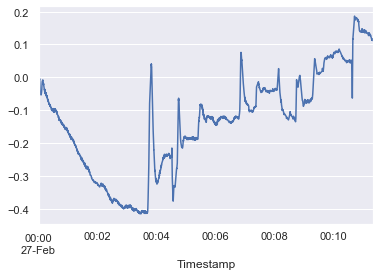

In [23]:
s = s - background
s.plot()

## Examine Data as Difference Series

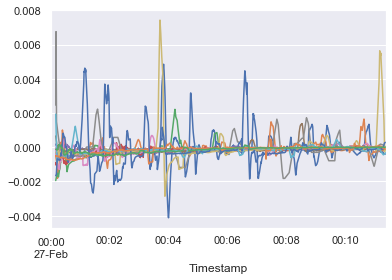

In [33]:
lower = [0, 1, 6, 7, 8, 9, 10, 11, 12, 16, 19, 24, 25]
cols = [df.columns[x] for x in lower]
lowers_df = df[cols]
lowers_df.rolling(100).mean().diff().plot(legend=False)

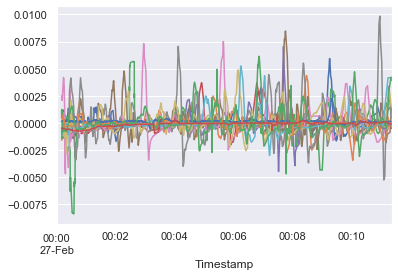

In [34]:
higher = [2, 3, 4, 5, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24]
cols = [df.columns[x] for x in higher]
highers_df = df[cols]
highers_df.rolling(100).mean().diff().plot(legend=False)

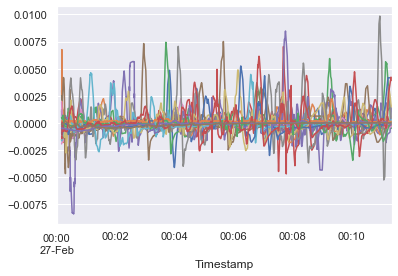

In [35]:
df.rolling(100).mean().diff().plot(legend=False)

In [ ]:
df = df.resample('1S')

idea: model the skin response data with a Gaussian Mixture Model, model the audio features as a Gaussian Mixture Model, measure the difference between the two models, and learn to minimize the difference between the models by weighting the audio features.

# PoC: Peaks for One Subject

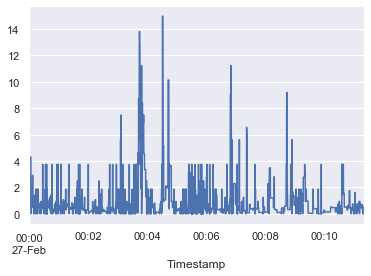

In [80]:
diff = abs(df['D5S2P2'].diff() * 1000)
diff.plot()
#subject_series.head()

In [81]:
diff.describe()

count    6815.000000
mean        0.800769
std         1.460598
min         0.000000
25%         0.149813
50%         0.382175
75%         0.749064
max        14.981273
Name: D5S2P2, dtype: float64

In [82]:
diff.quantile(.98)

5.617977528089735

In [88]:
diff = pd.DataFrame(diff)
diff = diff[1:]
diff.head()

,D5S2P2
Timestamp,
2019-02-27 00:00:00.100000,0.124844
2019-02-27 00:00:00.200000,0.124844
2019-02-27 00:00:00.300000,0.124844
2019-02-27 00:00:00.400000,0.124844
2019-02-27 00:00:00.500000,0.124844
